In [1]:
import pytz
import os
import sqlite3
import re
import uproot
import IPython
import sys
import copy
import numpy as np
import pandas as pd
import pymap3d as pm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pandasql import sqldf
from rnog_data.runtable import RunTable
from datetime import datetime, timedelta
from matplotlib.ticker import MaxNLocator
from scipy.fft import fft
from scipy.signal import stft
from NuRadioReco.modules.io.RNO_G.readRNOGDataMattak import readRNOGData
from NuRadioReco.utilities import units
from Flight import Flight
from IPython.display import clear_output


pd.options.display.float_format = '{:20,.15f}'.format
#-------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------
from FlightTracker import FlightTracker

current_month = '04'
next_month = '08'

start_time=f'2023-{current_month}-01 00:00:00'
stop_time=f'2023-{next_month}-01 00:00:00'

#start_time=f'2023-01-01 00:00:00'
#stop_time=f'2024-01-01 00:00:00'

tracker_initial = FlightTracker(start_time, stop_time, destination='./flights/flights_2023.db', already_calculated=True)
tracker = copy.deepcopy(tracker_initial) # make a new instance of the tracker
print(len(tracker.flights), len(tracker.flights_distinct))
tracker.flights_distinct

422465 2424


,index,flightnumber,date,filename,mintime,maxtime,min_r,min_z,theta
0,3261,DLH9922,2023-04-01,2023.04.01-051111.db,2023-04-01 00:42:32.100000,2023-04-01 01:01:07.500000,33.100000000000001,10.800000000000001,15.000000000000000
1,3262,N/A,2023-04-01,2023.04.01-051111.db,2023-04-01 00:59:37.100000,2023-04-01 03:40:13.900000,99.900000000000006,7.800000000000000,52.000000000000000
2,3263,N/A,2023-04-01,2023.04.01-051111.db,2023-04-01 05:21:28.400000,2023-04-01 18:48:53.900000,89.900000000000006,7.200000000000000,57.000000000000000
3,3264,CSN312,2023-04-01,2023.04.01-051111.db,2023-04-01 02:49:29.100000,2023-04-01 03:05:38.800000,72.799999999999997,7.700000000000000,49.000000000000000
4,3265,DLH491,2023-04-01,2023.04.01-051111.db,2023-04-01 03:20:48.200000,2023-04-01 03:40:39.000000,32.899999999999999,10.100000000000000,15.000000000000000
...,...,...,...,...,...,...,...,...,...
2419,5047,CFG2092,2023-07-31,2023.07.31-235039.db,2023-07-31 17:46:17.800000,2023-07-31 18:02:17.500000,72.400000000000006,9.199999999999999,10.000000000000000
2420,5048,DLH476,2023-07-31,2023.07.31-235039.db,2023-07-31 18:10:19.800000,2023-07-31 18:26:09.400000,32.899999999999999,10.100000000000000,15.000000000000000
2421,5049,SAS935,2023-07-31,2023.07.31-235039.db,2023-07-31 18:14:31.000000,2023-07-31 18:31:05.900000,35.899999999999999,8.600000000000000,15.000000000000000
2422,5050,CPA841,2023-07-31,2023.07.31-235039.db,2023-07-31 18:43:24.500000,2023-07-31 19:02:04.900000,54.899999999999999,9.199999999999999,55.000000000000000


In [2]:
'''con = sqlite3.connect('./header_files_for_time_range/header_2023')

temp_df = pd.read_sql_query(f'Select * from all_triggers_2023_04 where lt_triggers = 1', con)

con.close()
print(len(temp_df))'''

temp_df = pd.DataFrame()
con = sqlite3.connect('./header_files_for_time_range/header_2023')
for table in ['all_triggers_2023_04', 'all_triggers_2023_05', 'all_triggers_2023_06', 'all_triggers_2023_07']:
    temp = pd.read_sql_query(f'Select * From {table} where lt_triggers = 1', con)
    if(len(temp_df == 0)):
        temp_df = temp
    else:
        temp_df = pd.concat([temp_df, temp], ignore_index=True, sort=False)
con.close()
temp_df

,index,station_number,run_number,event_number,trigger_time,radiant_triggers,lt_triggers,force_triggers
0,1,11,2700,2855,"1,688,205,005.621175765991211",0,1,0
1,2,11,2700,2856,"1,688,205,005.662645816802979",0,1,0
2,4,11,2700,2858,"1,688,205,011.854097604751587",0,1,0
3,7,11,2700,2861,"1,688,205,016.713424682617188",0,1,0
4,9,11,2700,2863,"1,688,205,021.745759010314941",0,1,0
...,...,...,...,...,...,...,...,...
4055440,6788248,24,2030,189,"1,690,830,702.780166625976562",0,1,0
4055441,6788249,24,2030,190,"1,690,830,703.754574775695801",0,1,0
4055442,6788251,24,2030,192,"1,690,830,711.746086120605469",0,1,0
4055443,6788252,24,2030,193,"1,690,830,711.812068700790405",0,1,0


In [3]:
# add fk_date_flightnumber
flights_distinct = tracker.flights_distinct
flights_distinct = sqldf(''' 
SELECT
    *
    ,date || '_' || flightnumber as fk_date_flightnumber
FROM flights_distinct
''')
flights = tracker.flights
flights = sqldf(''' 
SELECT
    *
    ,date(readtime) || '_' || flightnumber as fk_date_flightnumber
FROM flights
''')


flights_distinct['mintime'] = pd.to_datetime(flights_distinct.mintime).dt.tz_localize('UTC')
flights_distinct['maxtime'] = pd.to_datetime(flights_distinct.maxtime).dt.tz_localize('UTC')

flights_distinct['mintime_millis'] = flights_distinct.mintime.astype(np.int64) // 10 ** 6
flights_distinct['maxtime_millis'] = flights_distinct.maxtime.astype(np.int64) // 10 ** 6

flights_distinct['mintime_sec'] = flights_distinct.mintime.astype(np.int64) // 10 ** 9
flights_distinct['maxtime_sec'] = flights_distinct.maxtime.astype(np.int64) // 10 ** 9

flights_distinct['ID'] = flights_distinct.index

temp_df['trigger_time_millis'] = (temp_df['trigger_time'] * (10 ** 3)).astype(np.int64)
temp_df['trigger_time_sec'] = (temp_df['trigger_time']).astype(np.int64)

flights_distinct

,index,flightnumber,date,filename,mintime,maxtime,min_r,min_z,theta,fk_date_flightnumber,mintime_millis,maxtime_millis,mintime_sec,maxtime_sec,ID
0,3261,DLH9922,2023-04-01,2023.04.01-051111.db,2023-04-01 00:42:32.100000+00:00,2023-04-01 01:01:07.500000+00:00,33.100000000000001,10.800000000000001,15.000000000000000,2023-04-01_DLH9922,1680309752100,1680310867500,1680309752,1680310867,0
1,3262,N/A,2023-04-01,2023.04.01-051111.db,2023-04-01 00:59:37.100000+00:00,2023-04-01 03:40:13.900000+00:00,99.900000000000006,7.800000000000000,52.000000000000000,2023-04-01_N/A,1680310777100,1680320413900,1680310777,1680320413,1
2,3263,N/A,2023-04-01,2023.04.01-051111.db,2023-04-01 05:21:28.400000+00:00,2023-04-01 18:48:53.900000+00:00,89.900000000000006,7.200000000000000,57.000000000000000,2023-04-01_N/A,1680326488400,1680374933900,1680326488,1680374933,2
3,3264,CSN312,2023-04-01,2023.04.01-051111.db,2023-04-01 02:49:29.100000+00:00,2023-04-01 03:05:38.800000+00:00,72.799999999999997,7.700000000000000,49.000000000000000,2023-04-01_CSN312,1680317369100,1680318338800,1680317369,1680318338,3
4,3265,DLH491,2023-04-01,2023.04.01-051111.db,2023-04-01 03:20:48.200000+00:00,2023-04-01 03:40:39+00:00,32.899999999999999,10.100000000000000,15.000000000000000,2023-04-01_DLH491,1680319248200,1680320439000,1680319248,1680320439,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2419,5047,CFG2092,2023-07-31,2023.07.31-235039.db,2023-07-31 17:46:17.800000+00:00,2023-07-31 18:02:17.500000+00:00,72.400000000000006,9.199999999999999,10.000000000000000,2023-07-31_CFG2092,1690825577800,1690826537500,1690825577,1690826537,2419
2420,5048,DLH476,2023-07-31,2023.07.31-235039.db,2023-07-31 18:10:19.800000+00:00,2023-07-31 18:26:09.400000+00:00,32.899999999999999,10.100000000000000,15.000000000000000,2023-07-31_DLH476,1690827019800,1690827969400,1690827019,1690827969,2420
2421,5049,SAS935,2023-07-31,2023.07.31-235039.db,2023-07-31 18:14:31+00:00,2023-07-31 18:31:05.900000+00:00,35.899999999999999,8.600000000000000,15.000000000000000,2023-07-31_SAS935,1690827271000,1690828265900,1690827271,1690828265,2421
2422,5050,CPA841,2023-07-31,2023.07.31-235039.db,2023-07-31 18:43:24.500000+00:00,2023-07-31 19:02:04.900000+00:00,54.899999999999999,9.199999999999999,55.000000000000000,2023-07-31_CPA841,1690829004500,1690830124900,1690829004,1690830124,2422


In [4]:
fk_timestamp = pd.DataFrame(columns = ['trigger_time_sec'], data = range(flights_distinct.mintime_millis.min() // 1000, flights_distinct.maxtime_millis.max() // 1000, 1))
fk_timestamp

,trigger_time_sec
0,1680309752
1,1680309753
2,1680309754
3,1680309755
4,1680309756
...,...
10520955,1690830707
10520956,1690830708
10520957,1690830709
10520958,1690830710


In [5]:
query = ''' 
SELECT
    count(trigger_time_sec) as sum_triggers_per_second
    --,station_number
    ,trigger_time_sec
    --,CASE 
    --    WHEN force_triggers = 1 THEN 1
    --    WHEN lt_triggers = 1 THEN 2
    --    WHEN radiant_triggers = 1 THEN 3
    --    ELSE -1
    --END AS trigger_type
    --,force_triggers
    --,lt_triggers
    --,radiant_triggers
    --,trigger_time_millis
FROM temp_df
--GROUP BY station_number, trigger_time_sec

GROUP BY trigger_time_sec
'''

test = sqldf(query)
test

,sum_triggers_per_second,trigger_time_sec
0,4,1688204998
1,2,1688204999
2,1,1688205000
3,2,1688205001
4,2,1688205002
...,...,...
1097741,2,1690830703
1097742,1,1690830704
1097743,1,1690830706
1097744,7,1690830707


In [6]:
fk_timestamp = fk_timestamp.merge(test, on=['trigger_time_sec'], how='left')

In [7]:
fk_timestamp

,trigger_time_sec,sum_triggers_per_second
0,1680309752,NaN
1,1680309753,NaN
2,1680309754,NaN
3,1680309755,NaN
4,1680309756,NaN
...,...,...
10520955,1690830707,7.000000000000000
10520956,1690830708,NaN
10520957,1690830709,NaN
10520958,1690830710,NaN


In [8]:
fk_timestamp.sum_triggers_per_second.fillna(0, inplace = True)
#fk_timestamp.station_number.fillna(-1, inplace=True)
#fk_timestamp.force_triggers.fillna(-1, inplace=True)

In [9]:
fk_timestamp

,trigger_time_sec,sum_triggers_per_second
0,1680309752,0.000000000000000
1,1680309753,0.000000000000000
2,1680309754,0.000000000000000
3,1680309755,0.000000000000000
4,1680309756,0.000000000000000
...,...,...
10520955,1690830707,7.000000000000000
10520956,1690830708,0.000000000000000
10520957,1690830709,0.000000000000000
10520958,1690830710,0.000000000000000


In [10]:
fk_timestamp['sum_triggers_per_second'] = fk_timestamp.sum_triggers_per_second.astype('uint16')

In [11]:
# join header information on flights_distinct
query = '''
SELECT 
    flightnumber
    ,fk_date_flightnumber
    --,station_number
    ,sum_triggers_per_second
    ,trigger_time_sec
FROM flights_distinct
LEFT JOIN ( 
            SELECT
                *
            FROM fk_timestamp
)t0

ON t0.trigger_time_sec > flights_distinct.mintime_sec
AND t0.trigger_time_sec < flights_distinct.maxtime_sec
WHERE trigger_time_sec is not null
and min_r < 50
--AND force_triggers = 0
--AND lt_triggers = 1
--AND radiant_triggers = 1
--GROUP BY fk_date_flightnumber, station_number, trigger_time_sec
GROUP BY fk_date_flightnumber, trigger_time_sec
'''

result = sqldf(query)
clear_output(wait=True)
result

,flightnumber,fk_date_flightnumber,sum_triggers_per_second,trigger_time_sec
0,CPA095,2023-04-01_CPA095,0,1680338251
1,CPA095,2023-04-01_CPA095,0,1680338252
2,CPA095,2023-04-01_CPA095,0,1680338253
3,CPA095,2023-04-01_CPA095,0,1680338254
4,CPA095,2023-04-01_CPA095,0,1680338255
...,...,...,...,...
2165558,SWR38J,2023-07-31_SWR38J,0,1690821694
2165559,SWR38J,2023-07-31_SWR38J,9,1690821695
2165560,SWR38J,2023-07-31_SWR38J,3,1690821696
2165561,SWR38J,2023-07-31_SWR38J,0,1690821697


In [12]:
sqldf('Select count(trigger_time_sec) as count, trigger_time_sec, GROUP_CONCAT(flightnumber ) AS flightnumbers  from result group By trigger_time_sec order by count desc')

,count,trigger_time_sec,flightnumbers
0,6,1684593656,"DLH452 ,KLM603 ,KLM677 ,N/A,SKIER62 ,SVA041"
1,6,1684593655,"DLH452 ,KLM603 ,KLM677 ,N/A,SKIER62 ,SVA041"
2,6,1684593654,"DLH452 ,KLM603 ,KLM677 ,N/A,SKIER62 ,SVA041"
3,6,1684593653,"DLH452 ,KLM603 ,KLM677 ,N/A,SKIER62 ,SVA041"
4,6,1684593652,"DLH452 ,KLM603 ,KLM677 ,N/A,SKIER62 ,SVA041"
...,...,...,...
1714719,1,1680309757,DLH9922
1714720,1,1680309756,DLH9922
1714721,1,1680309755,DLH9922
1714722,1,1680309754,DLH9922


In [13]:
query = '''
SELECT 
    *
FROM (
    SELECT count(trigger_time_sec) as count
    ,trigger_time_sec
    FROM result
    GROUP BY trigger_time_sec
)t0
WHERE count > 1
ORDER BY trigger_time_sec

'''

timestamps_to_exclude = sqldf(query)
timestamps_to_exclude

,count,trigger_time_sec
0,2,1680461028
1,2,1680461029
2,2,1680461030
3,2,1680461031
4,2,1680461032
...,...,...
371207,2,1690827964
371208,2,1690827965
371209,2,1690827966
371210,2,1690827967


In [14]:
result = result[~result['trigger_time_sec'].isin(timestamps_to_exclude['trigger_time_sec'])]
result = result[~result['flightnumber'].str.contains('SKI', na=False)]
result = result[~result['flightnumber'].str.contains('RCH108', na=False)]
result = result[~result['flightnumber'].str.contains('N/A', na=False)]
result

,flightnumber,fk_date_flightnumber,sum_triggers_per_second,trigger_time_sec
0,CPA095,2023-04-01_CPA095,0,1680338251
1,CPA095,2023-04-01_CPA095,0,1680338252
2,CPA095,2023-04-01_CPA095,0,1680338253
3,CPA095,2023-04-01_CPA095,0,1680338254
4,CPA095,2023-04-01_CPA095,0,1680338255
...,...,...,...,...
2165558,SWR38J,2023-07-31_SWR38J,0,1690821694
2165559,SWR38J,2023-07-31_SWR38J,9,1690821695
2165560,SWR38J,2023-07-31_SWR38J,3,1690821696
2165561,SWR38J,2023-07-31_SWR38J,0,1690821697


In [15]:
distinct_fk_date_flightnumber = sqldf("Select distinct fk_date_flightnumber from result")

In [16]:
#-------------------------------------------------------------------------------------------------------------------
def part_lin(x, times, r):
    return_linspace = []
    for element in x:
        #print()
        #print(times, element)
        #print(np.where(times <= element))
        #print()
        index = np.where(times <= element)[0][-1]
        if index >= (len(times) - 1):
            index = index - 1
            print(f'Index {index} out of range {len(times) - 1}')
        y2 = r.iloc[index+1]
        y1 = r.iloc[index]
        x2 = times.iloc[index+1]
        x1 = times.iloc[index]
        m = (y2 - y1) / (x2 - x1)
        t = y2 - m * x2
        return_linspace.append(m*element+t)
    len_ret = len(return_linspace)
    len_x = len(x)
    while(len_ret < len_x):
        return_linspace.append(0)

    return return_linspace

In [17]:
result_df = pd.DataFrame()
length = len(distinct_fk_date_flightnumber)

for i in range(length):
    clear_output(wait=True)
    #----------------------------------------------------------
    fk_date_flightnumber = distinct_fk_date_flightnumber.fk_date_flightnumber.iloc[i]
    print(fk_date_flightnumber, ', ', i, ':', length)

    #----------------------------------------------------------   
    flights_temp = flights[flights.fk_date_flightnumber == fk_date_flightnumber]
    
    times = pd.to_datetime(flights_temp.readtime_utc, format='ISO8601').astype('int64') / 10**9
    r = np.sqrt(flights_temp.r2)
    trigger_times = result[result.fk_date_flightnumber == fk_date_flightnumber].trigger_time_sec

    if((len(trigger_times) == 0) | len(times) == 0):
        print('len trigger_times = 0 or flightnunber == N/A or len(times) == 0')
        continue
    
    temp_table = pd.DataFrame(result[result.fk_date_flightnumber == fk_date_flightnumber].copy())
    print(f'flightnumber: {fk_date_flightnumber}')

    #print('--------------------------------------------')
    #print(times.min(), '<', trigger_times.min())
    #print(trigger_times.max(), '<', times.max())
    #print('--------------------------------------------')

    temp_table['d'] = part_lin(trigger_times, times, r)
    if(len(temp_table)):
        result_df = pd.concat([result_df, temp_table], ignore_index=True, sort=False)

result_df


2023-07-31_SWR38J   ,  674 : 675
flightnumber: 2023-07-31_SWR38J  


,flightnumber,fk_date_flightnumber,sum_triggers_per_second,trigger_time_sec,d
0,CPA095,2023-04-01_CPA095,0,1680338251,149.553518950939178
1,CPA095,2023-04-01_CPA095,0,1680338252,149.244452536106110
2,CPA095,2023-04-01_CPA095,0,1680338253,148.935386061668396
3,CPA095,2023-04-01_CPA095,0,1680338254,148.626319587230682
4,CPA095,2023-04-01_CPA095,0,1680338255,148.317253112792969
...,...,...,...,...,...
656880,SWR38J,2023-07-31_SWR38J,0,1690821694,147.745755314826965
656881,SWR38J,2023-07-31_SWR38J,9,1690821695,147.982259809970856
656882,SWR38J,2023-07-31_SWR38J,3,1690821696,148.218764305114746
656883,SWR38J,2023-07-31_SWR38J,0,1690821697,148.455268859863281


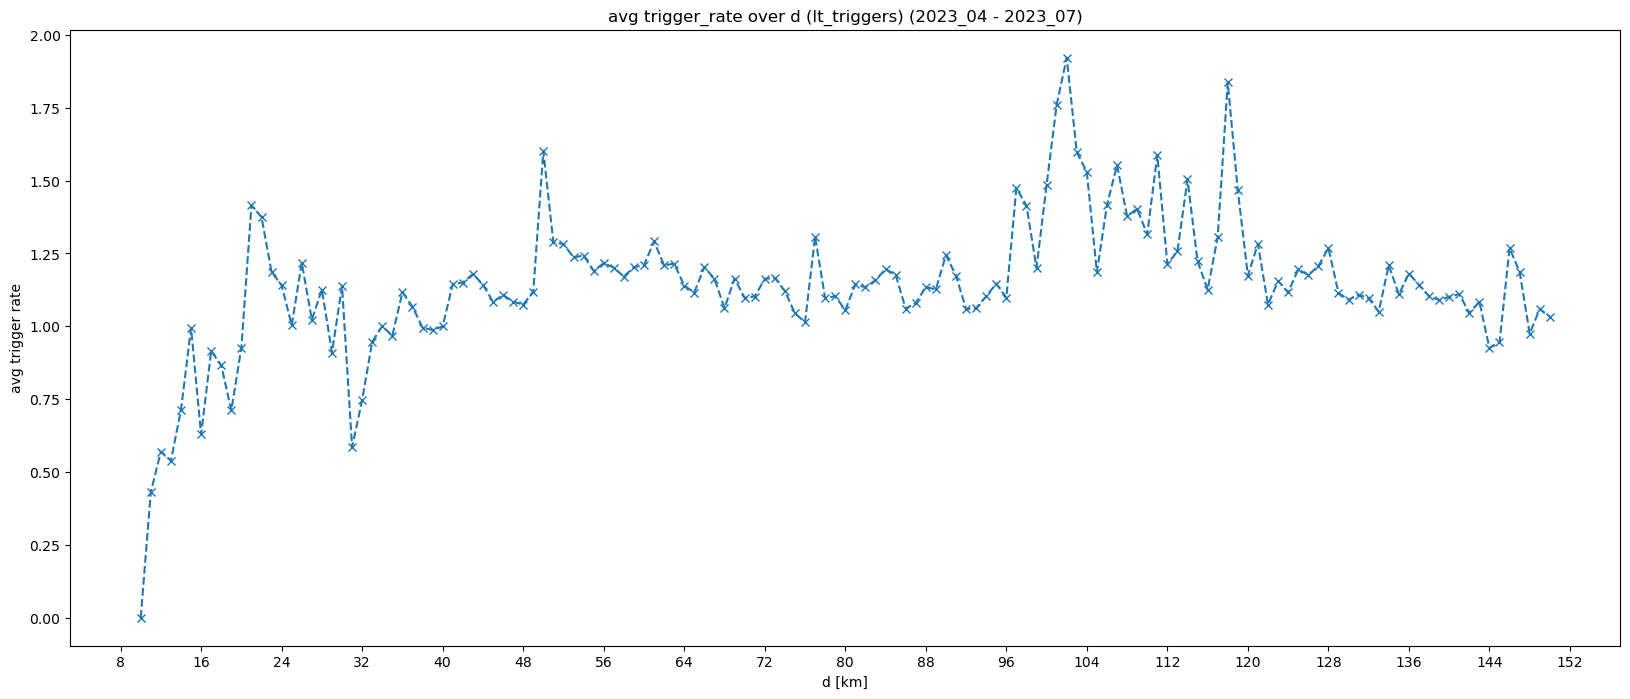

In [18]:
from matplotlib.ticker import MaxNLocator
test = sqldf('Select avg(sum_triggers_per_second) as avg_triggers_per_sec, round(d, 0) as d from result_df group by round(d, 0)')
plt.figure(figsize =(20, 8) ) 
plt.plot(test.d, test.avg_triggers_per_sec, 'x--')
plt.title('avg trigger_rate over d (lt_triggers) (2023_04 - 2023_07)')
plt.xlabel('d [km]')
plt.ylabel('avg trigger rate')
plt.gca().xaxis.set_major_locator(MaxNLocator(20))

Text(0, 0.5, 'count')

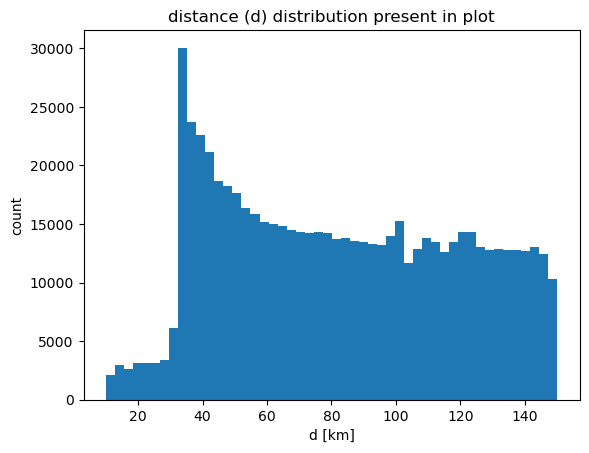

In [27]:
plt.hist(result_df.d, bins = 50)
plt.title('distance (d) distribution present in plot')
plt.xlabel('d [km]')
plt.ylabel('count')

In [20]:
was_ueber_ist = sqldf("Select distinct fk_date_flightnumber from result_df")

In [21]:
min_z = sqldf("Select fk_date_flightnumber, min_z from flights_distinct order by min_z asc")
min_z = min_z[min_z['fk_date_flightnumber'].isin(was_ueber_ist['fk_date_flightnumber'])]
min_z

,fk_date_flightnumber,min_z
78,2023-05-30_HFM313,6.800000000000000
79,2023-06-13_HFM813,6.800000000000000
114,2023-04-16_CES208,7.700000000000000
125,2023-05-29_UAE93Q,7.700000000000000
126,2023-06-10_AIC126,7.700000000000000
...,...,...
2410,2023-06-07_QQE580,11.400000000000000
2413,2023-06-29_QQE252,11.400000000000000
2414,2023-06-30_CFMHL,11.400000000000000
2420,2023-07-18_VJT794,12.000000000000000


In [22]:
test = FlightTracker("2023-07-13 00:00:00", "2023-07-14 00:00:00")
test.flights_distinct

,index,flightnumber,date,filename,mintime,maxtime,min_r,min_z,theta
0,0,N/A,2023-07-13,2023.07.13-234909.db,2023-07-13 05:26:46.600000,2023-07-13 17:19:14.500000,0.700000000000000,0.000000000000000,24.000000000000000
1,1,ELY005,2023-07-13,2023.07.13-234909.db,2023-07-13 05:26:56.700000,2023-07-13 05:42:26.200000,65.799999999999997,9.199999999999999,2.000000000000000
2,2,QTR65R,2023-07-13,2023.07.13-234909.db,2023-07-13 06:00:26.500000,2023-07-13 06:16:56.300000,32.200000000000003,8.300000000000001,18.000000000000000
3,3,THY8JK,2023-07-13,2023.07.13-234909.db,2023-07-13 07:20:14.700000,2023-07-13 07:36:04.300000,74.299999999999997,9.500000000000000,7.000000000000000
4,4,CPA843,2023-07-13,2023.07.13-234909.db,2023-07-13 10:21:52.700000,2023-07-13 10:38:37.600000,70.500000000000000,9.500000000000000,49.000000000000000
5,5,AFR163,2023-07-13,2023.07.13-234909.db,2023-07-13 10:40:58.300000,2023-07-13 10:56:47.900000,13.900000000000000,8.900000000000000,50.000000000000000
6,6,DLH490,2023-07-13,2023.07.13-234909.db,2023-07-13 13:01:19.200000,2023-07-13 13:09:51.700000,136.800000000000011,9.500000000000000,18.000000000000000
7,7,SKIER41,2023-07-13,2023.07.13-234909.db,2023-07-13 14:18:31.700000,2023-07-13 18:07:43.600000,0.600000000000000,0.000000000000000,47.000000000000000
8,8,EDW10K,2023-07-13,2023.07.13-234909.db,2023-07-13 16:01:51.900000,2023-07-13 16:19:47.100000,70.700000000000003,9.800000000000001,10.000000000000000
9,9,RCH108,2023-07-13,2023.07.13-234909.db,2023-07-13 16:19:47.100000,2023-07-13 19:13:42.800000,0.600000000000000,0.000000000000000,47.000000000000000


INFO:runtable_database:database connection to RNOG_live established


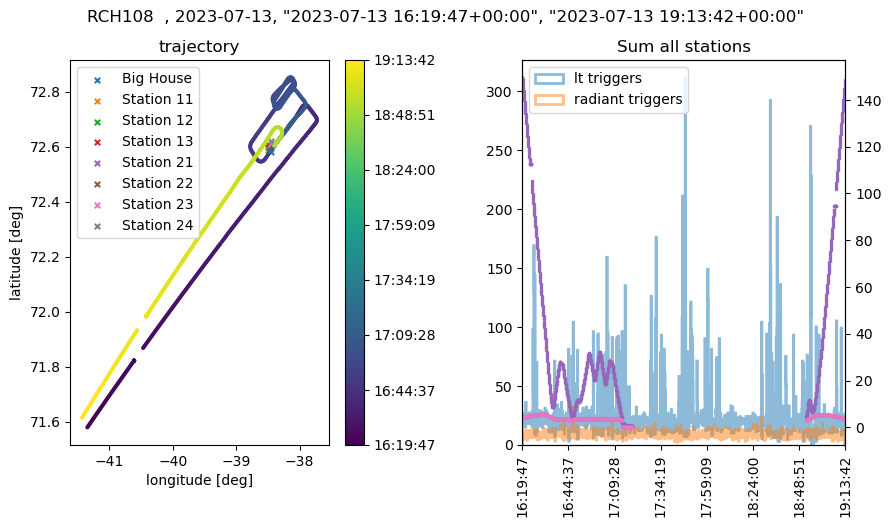

In [23]:
f = test.get_flight_by_index(9, filetype='headers.root')
f.plot_flight()

In [24]:
sqldf("Select * from was_ueber_ist where fk_date_flightnumber like '%RCH%' ")

,fk_date_flightnumber
0,2023-06-18_RCH310


In [25]:
test = FlightTracker("2023-06-18 00:00:00")
test.flights_distinct

,index,flightnumber,date,filename,mintime,maxtime,min_r,min_z,theta
0,0,AFR293,2023-06-18,2023.06.18-025627.db,2023-06-18 01:32:16.600000,2023-06-18 01:50:47.000000,11.300000000000001,8.900000000000000,45.000000000000000
1,1,N/A,2023-06-18,2023.06.18-025627.db,2023-06-18 01:47:56.200000,2023-06-18 01:48:46.500000,80.400000000000006,9.800000000000001,40.000000000000000
2,2,N/A,2023-06-18,2023.06.18-025627.db,2023-06-18 11:53:27.800000,2023-06-18 18:42:37.200000,69.599999999999994,8.100000000000000,67.000000000000000
3,3,CPA843,2023-06-18,2023.06.19-025631.db,2023-06-18 10:48:03.800000,2023-06-18 11:04:23.500000,70.400000000000006,8.900000000000000,49.000000000000000
4,4,N/A,2023-06-18,2023.06.19-025631.db,2023-06-18 01:47:56.200000,2023-06-18 01:48:46.500000,80.400000000000006,9.800000000000001,40.000000000000000
5,5,N/A,2023-06-18,2023.06.19-025631.db,2023-06-18 11:53:27.800000,2023-06-18 18:42:37.200000,69.599999999999994,8.100000000000000,67.000000000000000
6,6,DAL143,2023-06-18,2023.06.19-025631.db,2023-06-18 11:54:18.100000,2023-06-18 12:11:48.200000,32.299999999999997,8.600000000000000,18.000000000000000
7,7,DAL179,2023-06-18,2023.06.19-025631.db,2023-06-18 12:22:31.300000,2023-06-18 12:37:50.800000,32.399999999999999,8.600000000000000,18.000000000000000
8,8,OCN72,2023-06-18,2023.06.19-025631.db,2023-06-18 12:42:22.100000,2023-06-18 12:58:26.800000,32.600000000000001,9.600000000000000,15.000000000000000
9,9,DLH490,2023-06-18,2023.06.19-025631.db,2023-06-18 13:14:21.400000,2023-06-18 13:22:33.800000,136.800000000000011,8.600000000000000,18.000000000000000


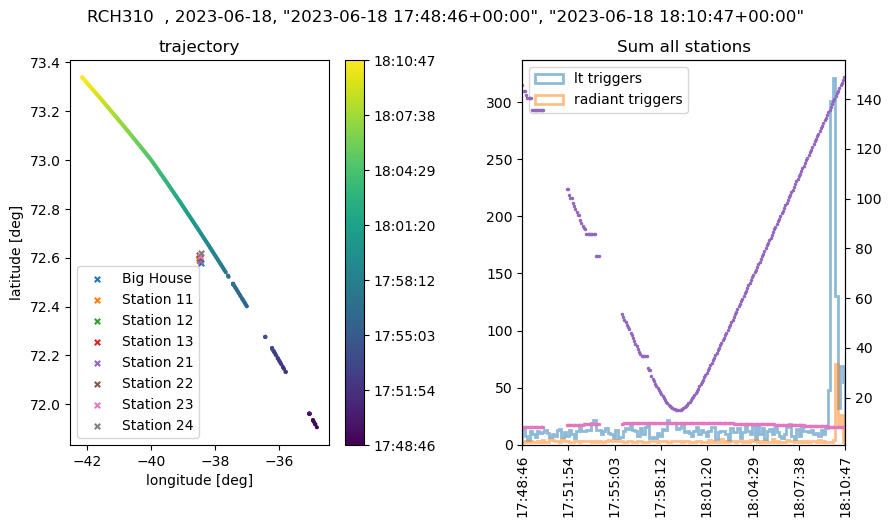

In [26]:
f = test.get_flight_by_index(18, filetype='headers.root')
f.plot_flight()